In [1]:
from pandas import *
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import matplotlib
import numpy
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import requests
binance  = "https://www.binance.com/api/v1/klines?symbol=BTCUSDT&interval=1d"
r = requests.get(binance)
data = r.json()

from math import log10
df = DataFrame(columns=["price"])
for row in data:
    df = df.append(DataFrame([float(row[1])],columns=df.columns))
df.index = [i for i in range(df.shape[0])]
df

,price
0,4261.48
1,4285.08
2,4108.37
3,4120.98
4,4069.13
5,4016.00
6,4040.00
7,4147.00
8,4316.01
9,4280.71


In [3]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# create a differenced series
def difference_arima(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value) 
    return diff

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, test_size, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train, test = X[0:-test_size], X[-test_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        interval = 7
        diff = difference_arima(history, interval)
        
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, interval)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse,predictions

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, test_size,p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    preds = list()
    best_preds = list()
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    #print(order)
                    mse,preds = evaluate_arima_model(dataset, test_size, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        best_preds = [p for p in preds]
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_preds

In [4]:
import time
p_values = range(0, 7)
d_values = range(0, 7)
q_values = range(0, 7)

warnings.filterwarnings("ignore")
test_size=30
date_index = date_range('08-01-2017',periods=df.shape[0],freq='D')
series = Series(df['price'].values,index=date_index)

st = time.time()
predictions = evaluate_models(series.values,test_size, p_values, d_values, q_values)
ft = time.time()

ARIMA(0, 0, 1) RMSE=678.497
ARIMA(0, 1, 1) RMSE=583.608
ARIMA(0, 1, 2) RMSE=584.829
ARIMA(0, 1, 3) RMSE=585.311
ARIMA(0, 1, 4) RMSE=574.417
ARIMA(0, 1, 5) RMSE=559.562
ARIMA(0, 1, 6) RMSE=538.970
ARIMA(0, 2, 1) RMSE=564.872
ARIMA(0, 2, 2) RMSE=585.093
ARIMA(1, 0, 0) RMSE=527.927
ARIMA(1, 0, 1) RMSE=553.204
ARIMA(1, 0, 2) RMSE=553.943
ARIMA(1, 0, 3) RMSE=555.553
ARIMA(1, 0, 4) RMSE=555.426
ARIMA(1, 0, 5) RMSE=437.489
ARIMA(1, 0, 6) RMSE=447.558
ARIMA(1, 1, 0) RMSE=579.720
ARIMA(1, 1, 1) RMSE=587.435
ARIMA(1, 1, 2) RMSE=552.249
ARIMA(1, 1, 3) RMSE=553.094
ARIMA(1, 1, 4) RMSE=565.846
ARIMA(1, 1, 5) RMSE=559.849
ARIMA(1, 1, 6) RMSE=438.444
ARIMA(1, 2, 0) RMSE=728.322
ARIMA(1, 2, 1) RMSE=581.254
ARIMA(1, 2, 2) RMSE=588.692
ARIMA(1, 2, 3) RMSE=587.613
ARIMA(1, 2, 4) RMSE=587.635
ARIMA(1, 2, 5) RMSE=565.240
ARIMA(1, 2, 6) RMSE=524.174
ARIMA(2, 0, 0) RMSE=551.954
ARIMA(2, 0, 1) RMSE=554.324
ARIMA(2, 0, 2) RMSE=551.439
ARIMA(2, 0, 3) RMSE=545.802
ARIMA(2, 0, 4) RMSE=514.859
ARIMA(2, 0, 5) RMSE=

In [5]:
if type(predictions[0]) != numpy.float64:
    _preds = list()
    for x in predictions:
        _preds.append(x[0])
else: _preds = [p for p in predictions]

In [6]:
ft-st

2171.4391779899597

In [7]:
def sMAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / ((y_true + y_pred)/2) )) * 100
sMAPE(df['price'].values[-test_size:],_preds)

4.2145413976039636

In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(df['price'][-test_size:], _preds))
rms

430.1529496946479

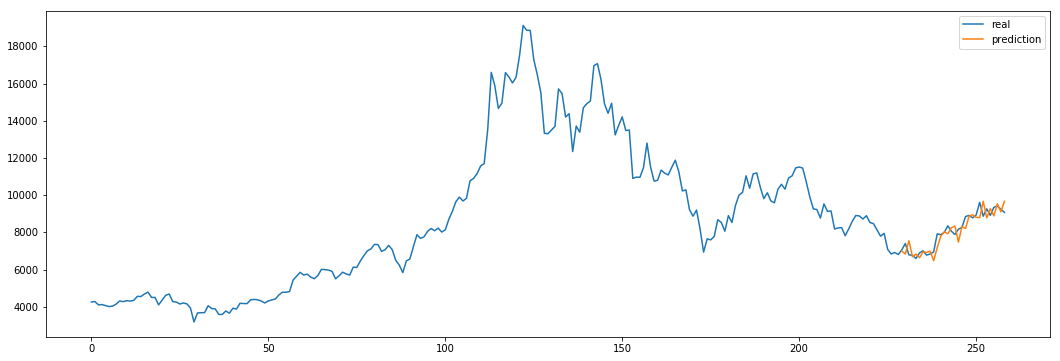

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,6))
plt.plot(Series(df['price'].values,index=range(df.shape[0])),label="real")
plt.plot(Series(_preds,index=range(df.shape[0]-test_size,df.shape[0])),label="prediction")
plt.legend()
plt.show()